## Model initialization

In [1]:
from __future__ import (division, print_function, absolute_import, unicode_literals)
from ema_workbench import (RealParameter, TimeSeriesOutcome, ema_logging, perform_experiments)
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework import (salib_samplers, IpyparallelEvaluator, samplers, util) 
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

import numpy.lib.recfunctions as rf
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import pandas as pd

C:\Users\Edzard\Anaconda\lib\site-packages\ema_workbench\em_framework\optimization.py:29: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Edzard\Anaconda\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [75]:
ema_logging.log_to_stderr(level=ema_logging.INFO)

model = ExcelModel("excelmodel", wd="./Models", model_file='MIDDEN Decarbonization options salt.xlsx')

#name of the sheet
model.sheet = "Experiment"

# Specification of the uncertainties
model.uncertainties = [RealParameter("Price_scenario", 1, 4),                # Integer value 1, 2, 3
                       RealParameter("Discount_rate", 0.01, 0.05),           # May fluctuate between 2% and 5%
                       RealParameter("Production_uncertainty", 0.90, 1.10),  # May fluctuate between between 85% and 115% 
                       RealParameter("Efficiency_gain", 0.003, 0.007)]       # Yearly efficiency gain approx 0.5% (DNGVL)

# Specification of the policies
model.levers = [#RealParameter("Plant_number", 1, 5),               # 1=Hengelo; 2=Delfzijl; 3=Harlingen; 4=Veendam
                #RealParameter("Steam_tech_explored",0,4),          # 0=None; 1=CHP; 2=Electric boiler; 3=Steam from 3rd parties
                #RealParameter("Vapor_tech_explored",0,4),          # 0=None; 1=MEV(4); 2=MEV(5); 3=MVR; 4=Brine use in industry
                RealParameter("Steam_tech_amount", 0, 11),          # Integer value range 0 – 10
                RealParameter("Vapor_tech_amount", 0, 6),           # Integer value range 0 – 5
                RealParameter("Investment_year", 2020, 2031),       # Integer value range 2020 – 2025
                RealParameter("Gas_tax",0,0.2),                     # Varies between 0% and 20%
                RealParameter("Green_electricity_subsidy", 0, 0.2)] # Varies between 0% and 20%

# Specification of the outcomes
model.outcomes = [TimeSeriesOutcome("NPV"),
                  TimeSeriesOutcome("Energy_usage_change"),
                  TimeSeriesOutcome("Direct_emissions_change"),
                  TimeSeriesOutcome("Indirect_emissions_change"),
                  TimeSeriesOutcome("Emissions_change"),
                  TimeSeriesOutcome("P_direct_emission_change"),
                  TimeSeriesOutcome("P_indirect_emission_change")]

 ### Running experiment with policies


In [3]:
#Running with policies
n_scenarios = 50
n_policies = 50

counter = util.Counter()
policies = samplers.sample_levers(model, n_policies)

#Running in series
#results = perform_experiments(model, n_scenarios)
#experiments, outcomes = results

#Running in parallel
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)
experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 50 scenarios * 50 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[SpawnPoolWorker-1/INFO] finalizing
[SpawnPoolWorker-2/INFO] finalizing


In [4]:
# Inspection of outcomes of interest
oois = outcomes.keys()
for ooi in oois:
    value = outcomes[ooi]
    value = np.sum(value, axis=1)
    i=len(ooi)
    print(ooi, (20-i)*" ", np.mean(value), 3*" ", np.std(value))

NPV                   82143604.7368     66625766.958
Energy_usage_change   229190.844887     189368.321944
Direct_emissions_change  -164.717756702     86.8051662248
Indirect_emissions_change  192.129743681     103.368597856
Emissions_change      27.4119869784     22.6947230578
P_direct_emission_change  -214682627.91     644047881.697
P_indirect_emission_change  7.84022906527     5.06719664073


In [13]:
# Creating experiment DataFrame
experiment_data=pd.DataFrame(experiments)
outcome_data = pd.DataFrame()
for ooi in oois:
    outcome_data[ooi]=outcomes[ooi][:,0,0]

# Chaning scenario and policy values to integers to account for how model interprets them
experiment_data[['Price_scenario','Steam_tech_amount','Vapor_tech_amount','Investment_year']]=experiment_data[['Price_scenario','Steam_tech_amount','Vapor_tech_amount','Investment_year']].astype(int).astype(float)

In [14]:
results_df=pd.concat([experiment_data, outcome_data], axis=1)
results_df.head(3)

,Discount_rate,Efficiency_gain,Price_scenario,Production_uncertainty,Gas_tax,Green_electricity_subsidy,Investment_year,Steam_tech_amount,Vapor_tech_amount,scenario_id,policy,model,NPV,Energy_usage_change,Direct_emissions_change,Indirect_emissions_change,Emissions_change,P_direct_emission_change,P_indirect_emission_change
0,0.034036,0.006274,3.0,0.957272,0.127716,0.002214,2027.0,1.0,2.0,0,"{'Gas_tax': 0.12771614916946036, 'Green_electr...",excelmodel,3.517517e+07,-76253.016365,-146.379806,167.246707,20.866901,-0.615886,7.074477
1,0.027125,0.004172,1.0,1.026961,0.127716,0.002214,2027.0,1.0,2.0,1,"{'Gas_tax': 0.12771614916946036, 'Green_electr...",excelmodel,1.203312e+08,19884.028742,-154.649986,184.415198,29.765212,-0.606528,7.271348
2,0.019482,0.006103,1.0,0.934727,0.127716,0.002214,2027.0,1.0,2.0,2,"{'Gas_tax': 0.12771614916946036, 'Green_electr...",excelmodel,7.625807e+07,-66989.687075,-142.757189,163.674549,20.917360,-0.615131,7.090361


## Scenario discovery

In [56]:
outcome_data_test=outcome_data
outcome_data_test['P_direct_emission_change_negative']=outcome_data_test.P_direct_emission_change<0
outcome_data_test['P_indirect_emission_change_negative']=outcome_data_test.P_indirect_emission_change<5.25
outcome_data_test['P_both_emission_change_negative']=outcome_data_test['P_direct_emission_change_negative']&outcome_data_test['P_indirect_emission_change_negative']

outcome_data_test['Positive_NPV']=outcome_data_test.NPV>0

In [58]:
# Selecting relevant dataframes for scenario analysis
x_df=experiment_data.ix[:,0:4]
#x_df=experiment_data[['Discount_rate','Efficiency_gain','Production_uncertainty']]
y_df=outcome_data['P_direct_emission_change_negative']&outcome_data_test['Positive_NPV']#&outcome_data_test['P_indirect_emission_change_negative']

# Converting dataframes to arrays
x = x_df.to_records()
y = y_df.values

# Running the Patient rule induction (PRIM) algorithm 
prim_alg = prim.Prim(x,y, threshold=0.3)
box_1 = prim_alg.find_box()

[MainProcess/INFO] 2500 points remaining, containing 2252 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.38, coverage: 0.4218472468916519, density: 1.0 restricted_dimensions: 1.0


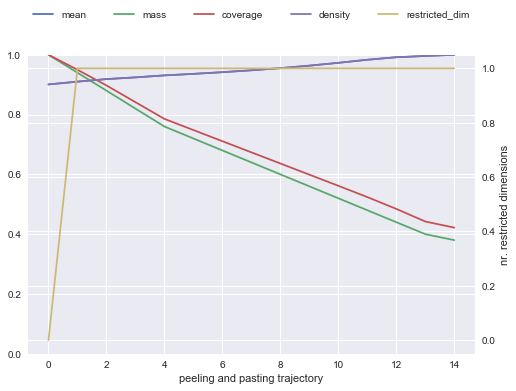

In [59]:
box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

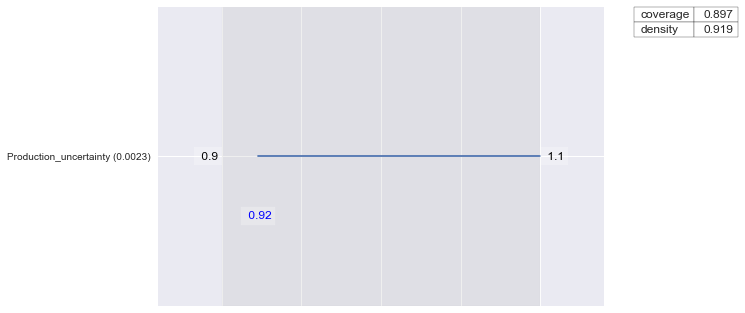

In [60]:
box_1.inspect(2, style='graph')
plt.show()

## Multi-objective robust optimization

In [61]:
import functools
from ema_workbench.em_framework.samplers import sample_uncertainties

In [73]:
MAXIMIZE = TimeSeriesOutcome.MAXIMIZE  # @UndefinedVariable
MINIMIZE = TimeSeriesOutcome.MINIMIZE  # @UndefinedVariable

robustness_functions = [TimeSeriesOutcome("NPV", kind=TimeSeriesOutcome.MAXIMIZE, 
                        variable_name='Mean_NPV', function=np.mean),
                        TimeSeriesOutcome("P_direct_emission_change", kind=TimeSeriesOutcome.MINIMIZE, 
                        variable_name='Mean_DEC', function=np.mean)
                       ]

n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)
nfe = 100

with SequentialEvaluator(model) as evaluator:
    robust_results = evaluator.robust_optimize(robustnes_functions, 
                            scenarios, nfe=nfe, population_size=25,
                            epsilons=[0.1,]*len(robustnes_functions))

TypeError: __init__() got an unexpected keyword argument 'kind'